Last updated: January 22, 2025



[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/iris-lew/projects/blob/main/project_006_AES/AES_1_data_exploration.ipynb)

Giving scores to students serve to evaluate their skills. Essays in particular evaluate the writer's proficiency in the language on multiple metrics: syntax, vocabulary, and grammar just to name a few. It is an arduous and monotonous task to read the essays and evaluate them, so it sounds like the perfect task to let AI do. These are called automatic essay scoring (AES) tasks. The fear with using AI to do such a task is that the AI might be trained on data that is not suited for the task (e.g., training it on English essays when it is grading French essays). Thus, the training data must be similar to the data it is being tested on.

I'd like to examine the use of automatic essay scoring and whether it would systematically produce different scores for English Language Learners (ELLs) as compared to native English speakers, signaling that these are actually two separate populations of essays.

There are a few [publicly available datasets](https://catalpa-cl.github.io/EduScoringDatasets/) I can use, but I ultimately decided to use the ASAP-AES and ELLIPSE corpus.

# Setup

In [ ]:
### only used for Google Colab
import os
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
%cd /content/gdrive/MyDrive/

Mounted at /content/gdrive
/content/gdrive/MyDrive


I stored the datasets under the data folder and will be operating out of there.

In [ ]:
%cd data

/content/gdrive/MyDrive/data


In [ ]:
# libraries
import numpy as np
import pandas as pd
import math

import random

import matplotlib.pyplot as plt

from os import path
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator

In [ ]:
# Global variable settings
random.seed(0)

# Data Exploration

I have two datasets: the [Automated Student Assessment Prize (ASAP) dataset](https://www.kaggle.com/c/asap-aes/overview) and the [English Language Learner Insight, Proficiency and Skills Evaluation (ELLIPSE) Corpus](https://github.com/scrosseye/ELLIPSE-Corpus).

The ASAP dataset contains around 12,976 essays that are 150-550 words long. There are eight different sets, each with different prompts. These essays were written by students from Grade 7 to Grade 10. As it originated as a Kaggle competition, the dataset is already split up into its training, validation, and test sets.

*   training_set_rel3.tsv
*   valid_set.tsv
*   test_set.tsv

The ELLIPSE Corpus is a set of about 6,500 ELL writing samples. The corpus only contains a training and a test set.

*   ELLIPSE_Final_github_train.csv
*   ELLIPSE_Final_github_test.csv




In [ ]:
asap_train = pd.read_csv('training_set_rel3.tsv', sep='\t', header=0, encoding="ISO-8859-1")
asap_valid = pd.read_csv('valid_set.tsv', sep='\t', header=0, encoding="ISO-8859-1")
asap_test = pd.read_csv('test_set.tsv', sep='\t', header=0, encoding="ISO-8859-1")

ell_train = pd.read_csv("ELLIPSE_Final_github_train.csv")
ell_test = pd.read_csv("ELLIPSE_Final_github_test.csv")

## ASAP Exploration

In [ ]:
asap_train.head(1)

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4,4,NaN,8,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
asap_train['character_count'] = asap_train['essay'].str.len()
asap_train['word_count'] = asap_train['essay'].str.split().str.len()

In [ ]:
asap_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12976 entries, 0 to 12975
Data columns (total 30 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   essay_id         12976 non-null  int64  
 1   essay_set        12976 non-null  int64  
 2   essay            12976 non-null  object 
 3   rater1_domain1   12976 non-null  int64  
 4   rater2_domain1   12976 non-null  int64  
 5   rater3_domain1   128 non-null    float64
 6   domain1_score    12976 non-null  int64  
 7   rater1_domain2   1800 non-null   float64
 8   rater2_domain2   1800 non-null   float64
 9   domain2_score    1800 non-null   float64
 10  rater1_trait1    2292 non-null   float64
 11  rater1_trait2    2292 non-null   float64
 12  rater1_trait3    2292 non-null   float64
 13  rater1_trait4    2292 non-null   float64
 14  rater1_trait5    723 non-null    float64
 15  rater1_trait6    723 non-null    float64
 16  rater2_trait1    2292 non-null   float64
 17  rater2_trait

There are multiple rating columns I could use. I can find the prompt of the essays and the scoring guidelines (within each set) inside the "Essay_Set_Descriptions" folder found under the data downloads in Kaggle. Judging from the scoring guidelines, I can assume that there are two graders that are scoring domain 1. The resolved score between them will be `domain1_score`. The Kaggle description states that there will be some essays in Set 8 that will have a 3rd rater.

I can produce histograms of the scores and the ratings provided by the raters to see the distribution of scores.

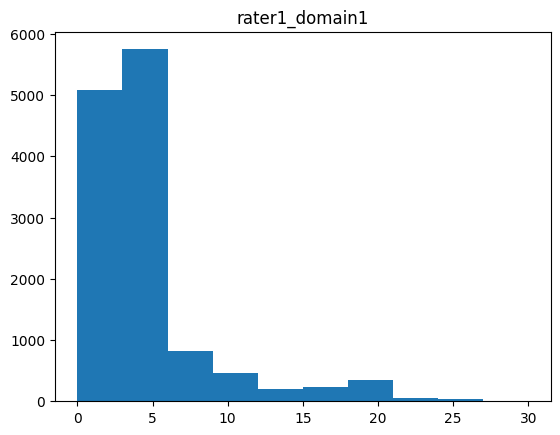

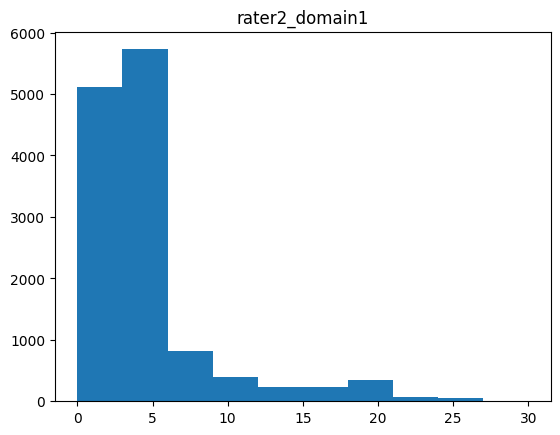

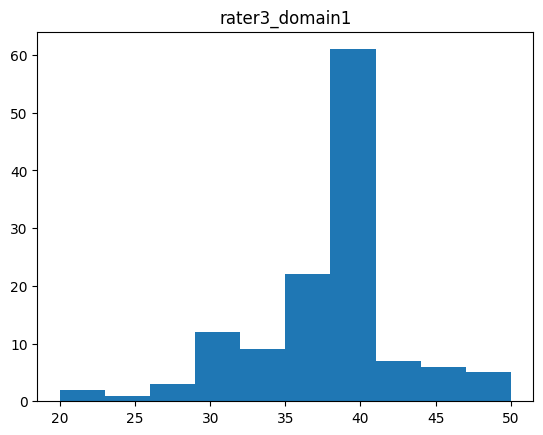

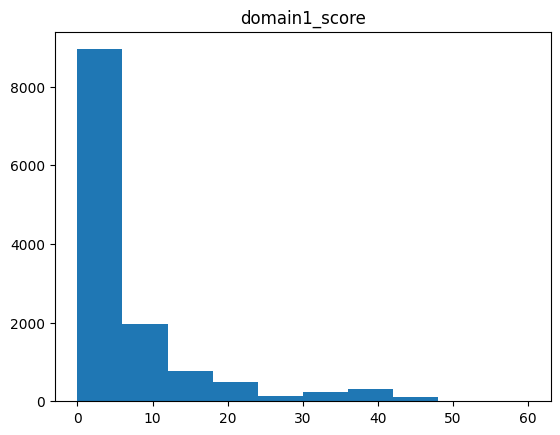

In [ ]:
num_columns = asap_train.columns[3:7]

for i in num_columns:
  plt.hist(asap_train[i])
  plt.title(i)
  plt.show()

In [ ]:
asap_train[['domain1_score','rater1_domain1','rater2_domain1','rater3_domain1']].value_counts(dropna=False).sort_index()

domain1_score  rater1_domain1  rater2_domain1  rater3_domain1
0              0               0               NaN               412
                               1               NaN                 1
                               2               NaN                 2
               1               0               NaN                 1
               2               0               NaN                 2
                                                                ... 
50             23              27              50.0                1
               25              25              NaN                 9
               27              20              50.0                1
55             30              25              NaN                 2
60             30              30              NaN                 1
Name: count, Length: 300, dtype: int64

In [ ]:
asap_train[['domain1_score','rater1_domain1','rater2_domain1']].value_counts(dropna=False).sort_index()

domain1_score  rater1_domain1  rater2_domain1
0              0               0                 412
                               1                   1
                               2                   2
               1               0                   1
               2               0                   2
                                                ... 
50             23              27                  1
               25              25                  9
               27              20                  1
55             30              25                  2
60             30              30                  1
Name: count, Length: 294, dtype: int64

In [ ]:
asap_train[['domain1_score']].value_counts(dropna=False).sort_index()

,count
domain1_score,
0,418
1,1736
2,2445
3,2830
4,1424
5,96
6,137
7,163
8,737


In [ ]:
asap_train[['rater1_domain1']].value_counts(dropna=False).sort_index()

,count
rater1_domain1,
0,462
1,2062
2,2556
3,2789
4,2254
5,704
6,266
7,127
8,420


In [ ]:
asap_train[['rater2_domain1']].value_counts(dropna=False).sort_index()

,count
rater2_domain1,
0,468
1,2091
2,2561
3,2698
4,2326
5,704
6,264
7,120
8,432


In [ ]:
asap_train['domain1_calculation'] = np.where(asap_train['rater1_domain1']+asap_train['rater2_domain1']==asap_train['domain1_score'], True,False)
asap_train['domain1_calculation'].value_counts(dropna=False)

,count
domain1_calculation,
False,8514
True,4462


In [ ]:
asap_train[['essay_set','rater3_domain1']].value_counts(dropna=False).sort_index()

essay_set  rater3_domain1
1          NaN               1783
2          NaN               1800
3          NaN               1726
4          NaN               1770
5          NaN               1805
6          NaN               1800
7          NaN               1569
8          20.0                 1
           22.0                 1
           24.0                 1
           26.0                 2
           28.0                 1
           30.0                12
           32.0                 2
           34.0                 7
           36.0                22
           38.0                 4
           40.0                57
           42.0                 7
           44.0                 4
           46.0                 2
           48.0                 1
           50.0                 4
           NaN                595
Name: count, dtype: int64

There appears a strong right skew with the majority of scores being less than 10 across all the essays. The `domain1_score` isn't just a simple addition between the two rater scores either. This is explained in the scoring guideline as scores not being adjacent to each other, but I noticed another problem that pops up due to the scoring guidelines.

The sets are not using the same scoring rubric. The range of the scores are different (for example, Set 1 has a rubric range of 1-6 but Set 4 has a rubric range of 0-3). This creates a problem in an automatic essay scoring system because the scores aren't equivalent. The scores function as an ordinal data point rather than a discrete data point. Even though from a model standpoint, I can treat these as ordinal data points, it would make interpreting the predicted scores difficult (how is a student meant to interpret a score of 3?).

I can repeat the same data exploration on Domain 2. Only essays found in the Set 2 are scored on two domains: writing applications and language conventions. This becomes a problem because the other sets are presumably taking this score into account as part of their `domain1_score` implicitly.

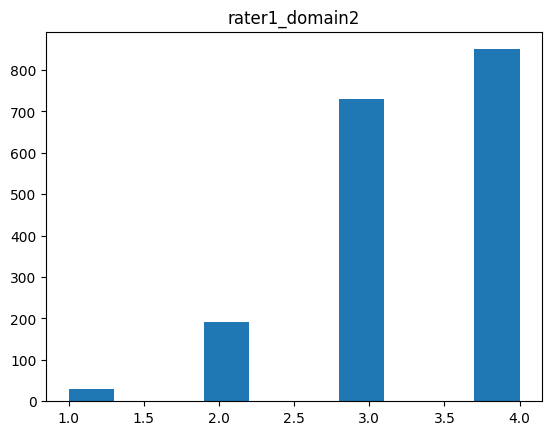

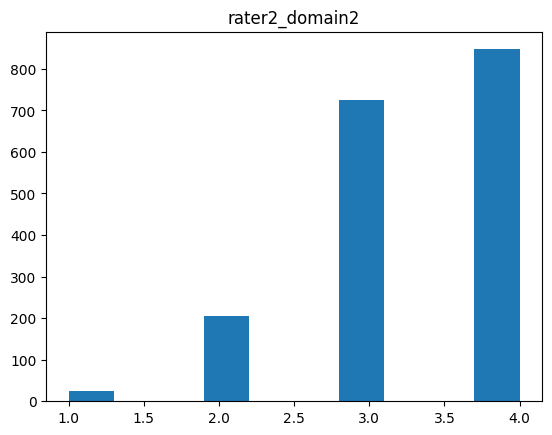

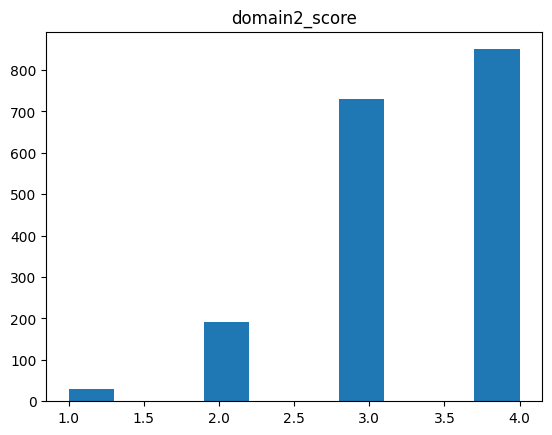

In [ ]:
num_columns = asap_train.columns[7:10]

for i in num_columns:
  plt.hist(asap_train[i])
  plt.title(i)
  plt.show()

In [ ]:
asap_train[['essay_set','domain2_score','rater1_domain2','rater2_domain2']].value_counts(dropna=False).sort_index()

essay_set  domain2_score  rater1_domain2  rater2_domain2
1          NaN            NaN             NaN               1783
2          1.0            1.0             1.0                 19
                                          2.0                 10
           2.0            2.0             1.0                  5
                                          2.0                141
                                          3.0                 43
                                          4.0                  2
           3.0            3.0             2.0                 51
                                          3.0                554
                                          4.0                125
           4.0            4.0             2.0                  2
                                          3.0                128
                                          4.0                720
3          NaN            NaN             NaN               1726
4          NaN            NaN             NaN               1770
5          NaN            NaN             NaN               1805
6          NaN            NaN             NaN               1800
7          NaN            NaN             NaN               1569
8          NaN            NaN             NaN                723
Name: count, dtype: int64

The scores on Domain 2 have a left skew. After examining the distribution of the scores and the individual raters, I needed to take a look at character count and word count distributions. This is because language models typically only take up to a certain number of "tokens" (words that are split up into parts so that language models are not duplicating words, e.g., "graduating" and "graduate" would likely both be "grad"). I needed to ensure that most of the essay will be captured in the model.

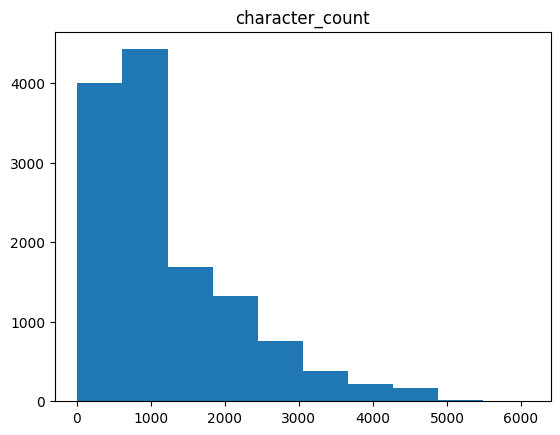

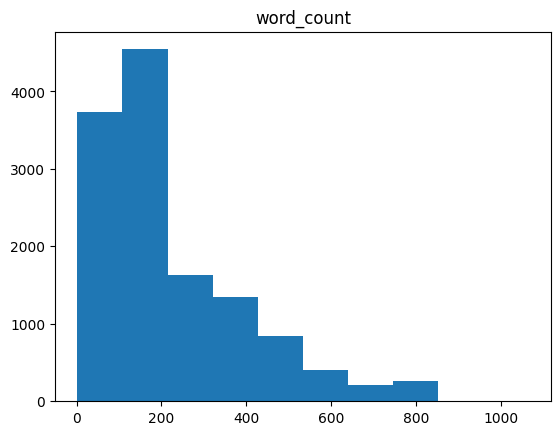

In [ ]:
num_columns = asap_train.columns[28:30]

for i in num_columns:
  plt.hist(asap_train[i])
  plt.title(i)
  plt.show()

Most tokenizers of the pre-trained LLMs will take up to 512 tokens, so the majority of the essays will be fully captured in the model. There will be some essays where the last portion will not be included in the training.

I created some word clouds to see if there are certain words that will appear in repeatedly. The word clouds also serve to confirm that the essays have different prompts for each set.

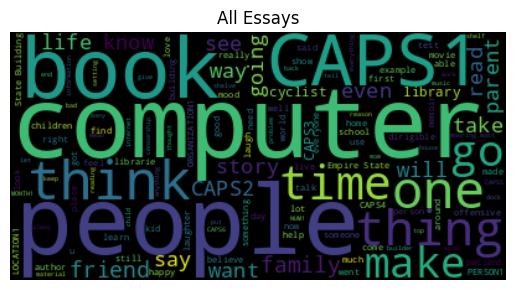

In [ ]:
text = " ".join(essay for essay in asap_train.essay)
stopwords = set(STOPWORDS)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('All Essays')
plt.axis("off")
plt.show()

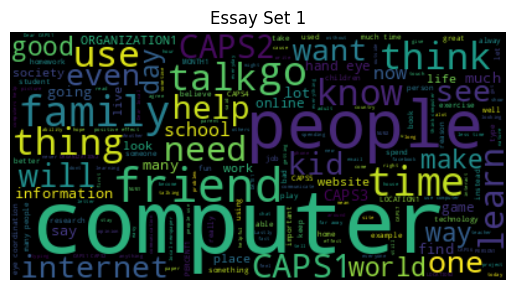

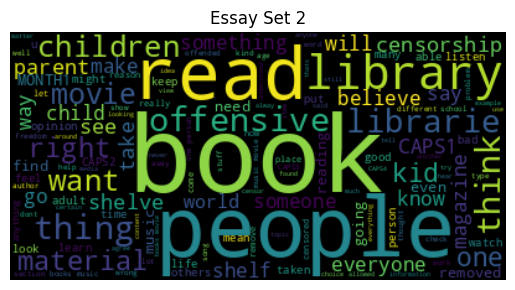

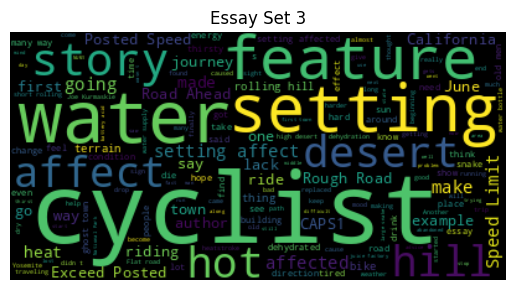

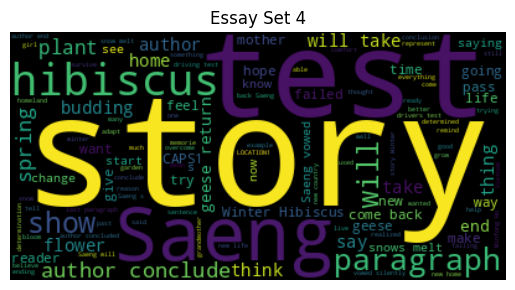

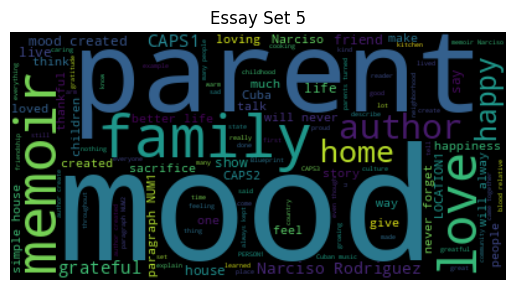

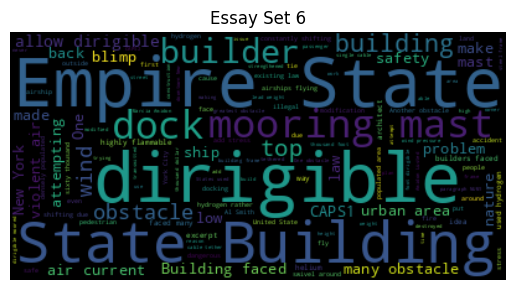

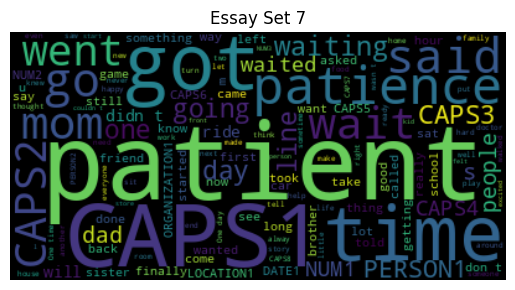

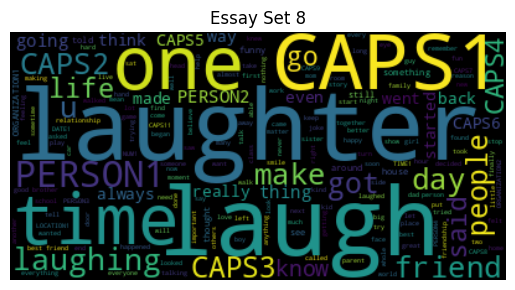

In [ ]:
for i in asap_train['essay_set'].unique():
  set = asap_train[asap_train['essay_set']==i]
  text = " ".join(essay for essay in set.essay)
  # Create and generate a word cloud image:
  wordcloud = WordCloud(stopwords=stopwords).generate(text)
  # Display the generated image:
  plt.imshow(wordcloud, interpolation='bilinear')
  plt.title('Essay Set '+str(i))
  plt.axis("off")
  plt.show()

While I'm not supposed to peek at the validation and test data, I wanted to confirm whether they share the same columns.

In [ ]:
asap_valid.head(1)

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,1788,1,"Dear @ORGANIZATION1, @CAPS1 more and more peop...",1788,NaN


In [ ]:
asap_test.head(1)

,essay_id,essay_set,essay,domain1_predictionid,domain2_predictionid
0,2383,1,I believe that computers have a positive effec...,2383,NaN


I see that they do not share the same columns as the training dataset but instead have an identifier so that the competition scorers can judge how accurate their models are. As I am not participating in the competition and instead exploring my own problem (whether ELL essays will be scored differently than the ASAP essays) I would have to instead split the ASAP training data so it can function as my training, validation, and test sets.

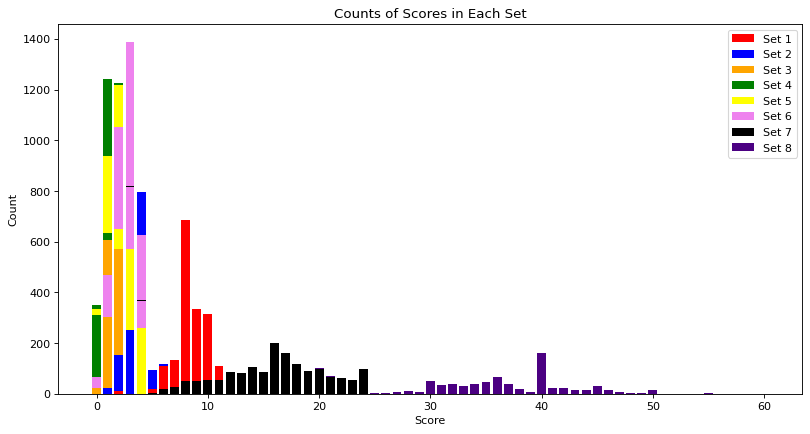

In [ ]:
# stacked bar chart of counts of domain1_score. colors are the essay_set.
set1_counts = asap_train[asap_train["essay_set"]==1]["domain1_score"].value_counts(dropna=False).reset_index()
set2_counts = asap_train[asap_train["essay_set"]==2]["domain1_score"].value_counts(dropna=False).reset_index()
set3_counts = asap_train[asap_train["essay_set"]==3]["domain1_score"].value_counts(dropna=False).reset_index()
set4_counts = asap_train[asap_train["essay_set"]==4]["domain1_score"].value_counts(dropna=False).reset_index()
set5_counts = asap_train[asap_train["essay_set"]==5]["domain1_score"].value_counts(dropna=False).reset_index()
set6_counts = asap_train[asap_train["essay_set"]==6]["domain1_score"].value_counts(dropna=False).reset_index()
set7_counts = asap_train[asap_train["essay_set"]==7]["domain1_score"].value_counts(dropna=False).reset_index()
set8_counts = asap_train[asap_train["essay_set"]==8]["domain1_score"].value_counts(dropna=False).reset_index()

possible_scores = range(0,61,1)
use = pd.DataFrame(possible_scores, columns=["score"])

set1 = use.merge(set1_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set1.fillna(0, inplace=True)

set2 = use.merge(set2_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set2.fillna(0, inplace=True)

set3 = use.merge(set3_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set3.fillna(0, inplace=True)

set4 = use.merge(set4_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set4.fillna(0, inplace=True)

set5 = use.merge(set5_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set5.fillna(0, inplace=True)

set6 = use.merge(set6_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set6.fillna(0, inplace=True)

set7 = use.merge(set7_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set7.fillna(0, inplace=True)

set8 = use.merge(set8_counts, how="left", left_on=["score"], right_on=["domain1_score"])
set8.fillna(0, inplace=True)


x = set1["score"]
y1 = set1["count"]
y2 = set2["count"]
y3 = set3["count"]
y4 = set4["count"]
y5 = set5["count"]
y6 = set6["count"]
y7 = set7["count"]
y8 = set8["count"]

plt.figure(figsize=(12, 6), dpi=80)
plt.bar(x, y1, color='r', label="Set 1")
plt.bar(x, y2, bottom=y1, color='b', label="Set 2")
plt.bar(x, y3, bottom=y2, color='orange', label="Set 3")
plt.bar(x, y4, bottom=y3, color='green', label="Set 4")
plt.bar(x, y5, bottom=y4, color='yellow', label="Set 5")
plt.bar(x, y6, bottom=y5, color='violet', label="Set 6")
plt.bar(x, y7, bottom=y6, color='black', label="Set 7")
plt.bar(x, y8, bottom=y7, color='indigo', label="Set 8")
plt.legend(loc='upper right')
plt.title("Counts of Scores in Each Set")
plt.xlabel('Score')
plt.ylabel('Count')
plt.show()

The data is not evenly represented by the sets. Some sets contain higher scores than others. This is likely due to the inconsistent scoring rubric across sets.

## ELLIPSE Exploration

I repeat the same data exploration but for the ELLIPSE Corpus.

In [ ]:
ell_train.head(1)

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,set
0,5661280443,Imagine if you could prove other people that y...,Male,8,Hispanic/Latino,420,431,431,18,4,...,Economically disadvantaged,Benefits of a problem,4.0,3.5,4.0,3.5,3.5,4.0,4.0,train


In [ ]:
ell_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3911 entries, 0 to 3910
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   text_id_kaggle     3911 non-null   object 
 1   full_text          3911 non-null   object 
 2   gender             3911 non-null   object 
 3   grade              3911 non-null   int64  
 4   race_ethnicity     3911 non-null   object 
 5   num_words          3911 non-null   int64  
 6   num_words2         3911 non-null   int64  
 7   num_words3         3911 non-null   int64  
 8   num_sent           3911 non-null   int64  
 9   num_para           3911 non-null   int64  
 10  num_word_div_para  3911 non-null   float64
 11  MTLD               3911 non-null   float64
 12  TTR                3911 non-null   float64
 13  Type               3911 non-null   int64  
 14  Token              3911 non-null   int64  
 15  task               3911 non-null   object 
 16  SES                3911 

There are more word counts, and more areas the essays are scored on. There is an overall score too.

In [ ]:
ell_train['character_count'] = ell_train['full_text'].str.len()
ell_train['word_count'] = ell_train['full_text'].str.split().str.len()
ell_train['word_count_same'] = np.where(ell_train['word_count']==ell_train['num_words3'],True,False)
ell_train['word_count_same'].value_counts().sort_index() # just numwords3 as the word count

,count
word_count_same,
True,3911


I first determined which word count I was going to use. This would be `num_words3` because it would be the same word count as in the ASAP dataset.

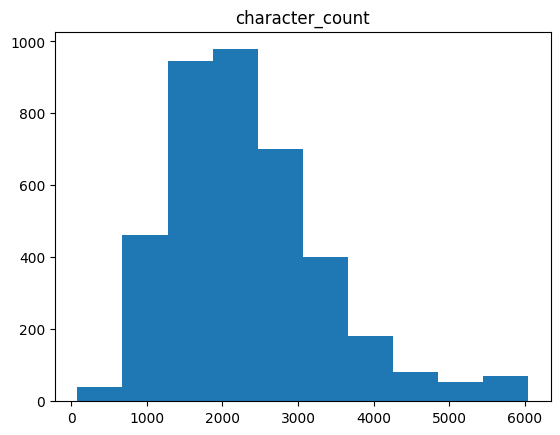

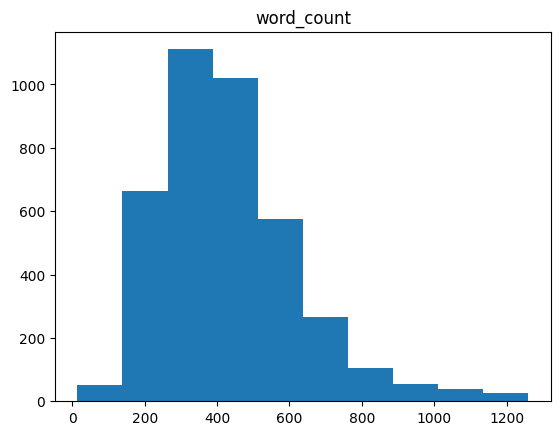

In [ ]:
num_columns = ell_train.columns[26:28]

for i in num_columns:
  plt.hist(ell_train[i])
  plt.title(i)
  plt.show()

As with the ASAP dataset, most essays are below 512 words, but there are a greater proportion of ELL essays that are above that limit. This means that there would be a substantial proportion of essays that are not fully captured during the prediction.

I also need to ensure that the grades the students are in are comparable.

In [ ]:
ell_train["grade"].value_counts().sort_index()

,count
grade,
8,975
9,26
10,214
11,1377
12,1319


The ASAP-AES dataset is comprised of 7-10th graders, but the ELLIPSE essays contain 8-12 graders. This means I will have to filter out the essays that are written by 11th and 12th graders. I would expect they would produce higher scores because the expectations of writing quality from 11th and 12th graders are higher too.

In [ ]:
ell_train["gender"].value_counts(dropna=False).sort_index() # roughly equal

,count
gender,
Female,1721
Male,2190


I also wanted to check the scores the students received.

In [ ]:
ell_train.iloc[:,18:25]

,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions
0,4.0,3.5,4.0,3.5,3.5,4.0,4.0
1,3.5,3.5,3.5,3.0,3.0,4.0,3.0
2,2.5,2.5,2.5,3.0,2.0,2.0,2.5
3,3.0,3.0,3.5,3.0,3.0,3.0,2.5
4,4.5,4.5,4.5,4.5,4.5,4.0,5.0
...,...,...,...,...,...,...,...
3906,3.0,3.5,3.0,3.0,2.5,3.0,3.5
3907,3.5,3.5,3.5,3.0,3.5,4.0,3.5
3908,2.5,2.0,3.0,2.5,2.0,2.5,3.0
3909,3.0,3.0,3.0,3.0,3.0,2.5,3.0


The scores ranged from 1-4, much different from the ASAP dataset, and the overall score is not a combination of the other columns. The scores are not discrete, but not entirely continuous either (there are .5 scores, but not .1 or .9).

Then I wanted to see if the essays were written on specific topics like the ASAP prompts. Unfortunately, I can only use word clouds to check as there are descriptions of prompts.

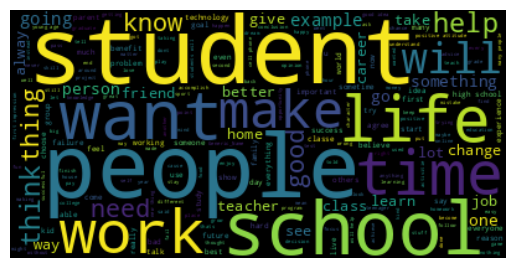

In [ ]:
text = " ".join(essay for essay in ell_train.full_text)

# Create and generate a word cloud image:
wordcloud = WordCloud(stopwords=stopwords).generate(text)

# Display the generated image:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

While it seems like there's a pattern of school, work, and social life appearing in the essays, it is ambiguous whether it is a specific prompt. It is unlikely that the topic is the same as any one of the ASAP prompts.


# Conclusion

These datasets aren't perfect. Even if I somehow create a model to use both training sets, there are some fundamental flaws with the data.

For the sake of my analysis, I will use the `domain1_score` from the ASAP dataset even though there are inconsistencies across sets for what each number means. I will also be treating it as a categorical value rather than a numerical value because I want to use a classifier model. This means that the proportion of values that show up in the training set will be related to how often the model can predict a number and the numerical meaning itself will be lost (i.e., a score of 4 can occur not because the essay is better written, but because the essay resembled those that scored 3 more). There will be difficulties with interpreting the scores in a practical sense (how is a student meant to interpret a score of 3?). There aren't enough essays with `domain2_score` separated out so I am unable to use `domain2_score`.

I am filtering so that only the 8-10th graders remain in the ELLIPSE dataset. This is to make it as comparable to the ASAP dataset as possible (so if there are any higher grades, it is not because the students are older). There are no 7th graders in the ELLIPSE corpus unfortunately, but at least this shouldn't bias the ELLIPSE to receive higher scores just because the students are expected to perform better.

In [ ]:
ell_train_fin = ell_train[ell_train['grade']<=10]
ell_test_fin = ell_test[ell_test['grade']<=10]

In [ ]:
ell_train_fin.head(1)

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,set,character_count,word_count,word_count_same
0,5661280443,Imagine if you could prove other people that y...,Male,8,Hispanic/Latino,420,431,431,18,4,...,3.5,4.0,3.5,3.5,4.0,4.0,train,2317,431,True


In [ ]:
ell_test_fin.head(1)

,text_id_kaggle,full_text,gender,grade,race_ethnicity,num_words,num_words2,num_words3,num_sent,num_para,...,SES,prompt,Overall,Cohesion,Syntax,Vocabulary,Phraseology,Grammar,Conventions,set
1,60346336449,"As being the youngest child, I have gained wis...",Male,8,Asian/Pacific Islander,405,434,427,15,5,...,Not economically disadvantaged,Learning from the experience of others,3.5,3.5,3.5,3.0,3.5,3.5,3.5,test


# Food For Thought

While universities and standardized tests may benefit from using an automatic essay scoring system, receiving an overall grade based on key metrics is generally not how people learn to improve. The problem with AI doing the grading is that teachers need to know what each student struggles with and then adjust their curriculum to focus on meeting learning goals. Unless they read the essay directly, it's hard to assess their skills. There is also the problem that the same score can mean different things. There needs to be consistency in what a score means because the AI model doesn't know any better.

In my master's degree, I've learned that it takes a minimum of around 3,000 essays to train, about 1,000 to validate, and about 1,000 to test a fine-tuned pre-trained large language model. This is a number that is difficult to collect at a classroom-level within one year. Let's say a school has 1,000 students per grade per year (according to [Public School Review](https://www.publicschoolreview.com/average-school-size-stats/national-data), the average school size is 512). The same course would need to be offered for five years with those same essays being graded and collected. The scoring rubric would also need to be the exact same for there to be enough essays to even fine-tune an AES system. This is unrealistic at a classroom or even a school-level because teachers review their curriculum and update it for subsequent years.

**Realistically, the only institutions that can collect thousands of essays on one topic relatively easily and score them using the same rubric would be institutions offering standardized tests.** They don't need to provide feedback on specific areas the students can improve on and just assign the score. The topic may differ year to year, but it is expected that a score of 3 means the same year to year if the prompt is mostly the same (e.g., a literary analysis of a given poem would have the same scoring criteria in 2015 and 2017 even if the poem is different). This means that the market for automatic essay scoring systems is actually quite small unless more standardized tests are offered (and that comes with its own set of controversies).